In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tfi_exact # for comparison

In [2]:
import a_mps
import b_model
import c_tebd
import d_dmrg

In [3]:
# a)
class TFIModel(b_model.TFIModel):
    """Extension of the TFIModel to define the MPO as well."""
    def __init__(self, L, J, g):
        super().__init__(L, J, g)  # calls the __init__() of b_model.TFIModel
        self.init_H_mpo()
    
    def init_H_mpo(self):
        """Initialize `H_mpo` Hamiltonian. Called by __init__()."""
        w_list = []
        for i in range(self.L):
            w = np.zeros((3, 3, self.d, self.d), dtype=np.float)
            w[0, 0,:, :] = w[2, 2, :, :] = self.id
            w[0, 1, :, :] = self.sigmax
            w[0, 2, :, :] = -self.g * self.sigmaz
            w[1, 2, :, :] = -self.J * self.sigmax
            w_list.append(w)
        self.H_mpo = w_list

The `TFIModel` class defined above is derived from the `b_model.TFIModel`.
Thus the method `energy()` is derived from the `b_model.TFIModel`.
The `__init__()` is overwritten by the above definition, which calls the previous `__init__(...)` of the 
`b_model.TFIModel` using the `super().__init__(...)` syntax.

In [4]:
# b)
model = TFIModel(14, 1., 1.5)
# compare to exact result
import tfi_exact
E_exact = tfi_exact.finite_gs_energy(model.L, model.J, model.g)
print("Exact diagonalization: E = {E:.13f}".format(E=E_exact))

psi = a_mps.init_spinup_MPS(model.L)
eng = d_dmrg.DMRGEngine(psi, model, chi_max=30, eps=1.e-13)
for i in range(10):
    eng.sweep()
    E = model.energy(psi)
    err = abs((E - E_exact) / E_exact)
    print("sweep {i:2d}: E = {E:.13f}, rel. error {err:.4e}".format(i=i + 1, E=E, err=err))
print("final bond dimensions: ", psi.get_chi())


Exact diagonalization: E = -23.2229594341173
sweep  1: E = -23.2249817680142, rel. error 8.7083e-05
sweep  2: E = -23.2229594423168, rel. error 3.5308e-10
sweep  3: E = -23.2229594341174, rel. error 3.3656e-15
sweep  4: E = -23.2229594341174, rel. error 3.2126e-15
sweep  5: E = -23.2229594341174, rel. error 2.9067e-15
sweep  6: E = -23.2229594341174, rel. error 2.9067e-15
sweep  7: E = -23.2229594341174, rel. error 3.5186e-15
sweep  8: E = -23.2229594341174, rel. error 3.2126e-15
sweep  9: E = -23.2229594341174, rel. error 2.9067e-15
sweep 10: E = -23.2229594341174, rel. error 2.9067e-15
final bond dimensions:  [2, 4, 8, 16, 23, 27, 30, 27, 23, 16, 8, 4, 2]


L = 14 g = 1.5
max chi =  30
L = 14 g = 1.0
max chi =  38
L = 14 g = 0.5
max chi =  32
L = 50 g = 1.5
i= 0
i= 1
i= 2
i= 3
i= 4
i= 5
i= 6
i= 7
i= 8
i= 9
max chi =  43
L = 50 g = 1.0
i= 0
i= 1
i= 2
i= 3
i= 4
i= 5
i= 6
i= 7
i= 8
i= 9
max chi =  115
L = 50 g = 0.5
i= 0
i= 1
i= 2
i= 3
i= 4
i= 5
i= 6
i= 7
i= 8
i= 9
max chi =  29


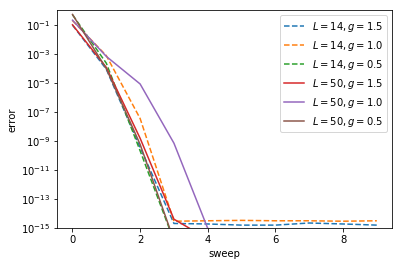

In [5]:
# Bonus: check the convergence for various parameters L, g
plt.figure()
params = [(14, 1.5), (14, 1.0), (14, 0.5), 
          (50, 1.5), (50, 1.0), (50, 0.5)]
for L, g in params:
    print("L =", L,  "g =", g)
    model = TFIModel(L, 1., g)
    psi = a_mps.init_spinup_MPS(model.L)
    eng = d_dmrg.DMRGEngine(psi, model, chi_max=120, eps=1.e-13)
    Es = []
    for i in range(10):
        Es.append(model.energy(psi))
        eng.sweep()
        if L > 20:
            print("i=", i)
    if L < 20:
        E_exact = tfi_exact.finite_gs_energy(model.L, model.J, model.g)
        linestyle = '--'
    else:
        E_exact = Es.pop()  # pop() removes the last element from the list
        linestyle = '-'
    Es = np.array(Es)
    lbl = '$L={L:d}, g={g:.1f}$'.format(L=L, g=g)
    plt.plot(np.arange(len(Es)), abs((Es - E_exact)/E_exact), label=lbl, linestyle=linestyle)
    print("max chi = ", max(psi.get_chi()))
plt.yscale('log')
plt.ylabel('error')
plt.xlabel('sweep')
plt.ylim(1.e-15, 1.)
plt.legend(loc='upper right')
plt.show()

In [6]:
# c)
def dmrg_gs(L, J, g, max_N_sweeps=10, chi_max=30, eps=1.e-10):
    model = TFIModel(L, J, g)
    psi = a_mps.init_spinup_MPS(L)
    eng = d_dmrg.DMRGEngine(psi, model, chi_max=chi_max, eps=eps)
    Eprev = np.inf
    for i in range(max_N_sweeps):
        eng.sweep()
        E = model.energy(psi)
        if L > 60:
            print(".", end='', flush=True)
        if abs((E - Eprev)/E) < eps:
            break
        Eprev = E
    print("max final bond dimension: ", max(psi.get_chi()))
    return model, psi

model, psi = dmrg_gs(14, 1., 1.0)
print(model.energy(psi))

max final bond dimension:  24
-17.47100405473177


In [7]:
# d)
Ls = [8, 16, 32, 64, 96, 128]
Ss = {}
for g in [1.5, 0.5, 1.0]:
    print('-'*40)
    print("g =", g)
    Ss[g] = []
    for L in Ls:
        print("L =", L)
        model, psi = dmrg_gs(L, 1., g, chi_max=150, eps=1.e-10)
        Ss[g].append(psi.entanglement_entropy()[L//2])

----------------------------------------
g = 1.5
L = 8
max final bond dimension:  12
L = 16
max final bond dimension:  20
L = 32
max final bond dimension:  21
L = 64
....max final bond dimension:  21
L = 96
....max final bond dimension:  21
L = 128
....max final bond dimension:  21
----------------------------------------
g = 0.5
L = 8
max final bond dimension:  13
L = 16
max final bond dimension:  20
L = 32
max final bond dimension:  20
L = 64
...max final bond dimension:  14
L = 96
...max final bond dimension:  14
L = 128
...max final bond dimension:  14
----------------------------------------
g = 1.0
L = 8
max final bond dimension:  14
L = 16
max final bond dimension:  27
L = 32
max final bond dimension:  45
L = 64
.....max final bond dimension:  71
L = 96
.....max final bond dimension:  88
L = 128
.....max final bond dimension:  102


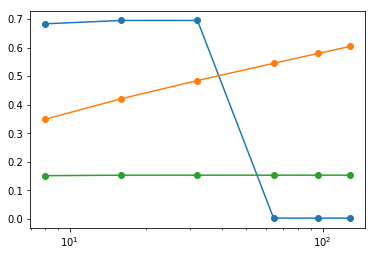

In [8]:
# quick first plot
plt.figure()
for g in sorted(Ss.keys()):
    plt.plot(Ls, Ss[g], marker='o', label="$g={g:.1f}$".format(g=g))
plt.xscale('log')
plt.show()

In [9]:
for L in [16, 64]:
    print("L = ", L)
    model, psi = dmrg_gs(L, 1., g=0.5, chi_max=150, eps=1.e-10)
    print("<Sx> =", np.mean(psi.site_expectation_value(model.sigmax)))

L =  16
max final bond dimension:  20
<Sx> = 9.517047374149875e-10
L =  64
...max final bond dimension:  14
<Sx> = -0.9608702294508029


## drop of the g=0.5 curve
The blue curve is for $g=0.5J$, where we have symmetry breaking. 
As we have seen during the Exact Diagonalization tutorials, on finite systems (with small $L$) its favorable to have a superposition of the two symmetry broken states $|\rightarrow \rightarrow \rightarrow \dots\rangle$ and $|\leftarrow \leftarrow \leftarrow \dots\rangle$ and a few smaller quantum fluctuations on top, which gives entanglement $S = \log(2) + \epsilon$.
With increasing $L$ the two symmetry broken states become degenerate to a higher degree than our machine precision such that a single one of them also looks like an exact eigenstate (although strictly speaking it's not).
You can see this by explicitly evaluating the expectation value of $\sigma_x$: for the (equal) superposition it's 0, while it is non-zero in the symmetry broken state $\rightarrow \rightarrow \rightarrow \dots\rangle$.

DMRG has the tendency to break the symmetry explicitly for symmetry broken systems, 
although it might be difficult to enforce.


fit coefficients [0.08518047 0.19149843]
central charge: c = 0.5110828491065277


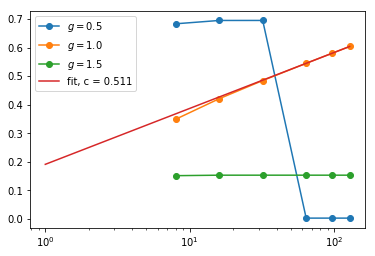

In [10]:
# d) second part: extract c
keep = -3  # use 3 largest points for the fit
Ls = np.array(Ls)
S_crit = Ss[1.0]
fitcoeff = np.polyfit(np.log(Ls[keep:]), S_crit[keep:], 1)
print("fit coefficients", fitcoeff)
c = fitcoeff[0]*6
print("central charge: c =", c)

plt.figure()
for g in sorted(Ss.keys()):
    plt.plot(Ls, Ss[g], marker='o', label='$g={g:.1f}$'.format(g=g))
Ls_line = [1, Ls[0], Ls[-1]]
plt.plot(Ls_line, fitcoeff[0] * np.log(Ls_line) + fitcoeff[1], label="fit, c = {c:.3f}".format(c=c))
plt.xscale('log')
plt.legend(loc='best')
plt.show()

In [11]:
# e)
def correlation_function(psi, X, Y, i):
    L = psi.L
    assert i < L
    corrs = []
    # first case: j = i
    # Note: psi.get_theta(i) = Lambda[i] B[i] with axes vL i vR
    theta = psi.get_theta1(i)  # vL i vR
    X_Y_theta = np.tensordot(np.dot(X, Y), # i [i*], [i] i*
                             theta, axes=([1], [1]))  # i [i*], vL [i] vR
    contr = np.tensordot(theta.conj(), X_Y_theta, axes=([0, 1, 2], [1, 0, 2]))  # [vL*] [i*] [vR*], [i] [vL] [vR]
    corrs.append(contr)
    # now for i < j
    theta = psi.get_theta1(i)  # vL i vR
    LP = np.tensordot(X, theta, axes=([1], [1]))  # i [i*], vL [i] vR
    LP = np.tensordot(theta.conj(), LP, axes=([0, 1], [1, 0])) # [vL*] [i*] vR*, [i] [vL] vR
    # now LP has axes vR*, vR
    for j in range(i+1, L):
        # contract with B Y B* to evalluate the correlation function for given j
        B = psi.Bs[j]  # vL j vR
        Y_B = np.tensordot(Y, B, axes=([1], [1])) # j [j*], vL [j] vR
        contr = np.tensordot(LP, Y_B, axes=([1], [1])) # vR* [vR], j [vL] vR
        contr = np.tensordot(contr, B.conj(), axes=([0, 1, 2], [0, 1, 2])) # [vR*] [j] [vR], [vL*] [j*] [vR*]
        corrs.append(contr.item())
        # get next LP for next i
        LP = np.tensordot(LP, B, axes=([1], [0])) # vR* [vR], [vL] j vR
        LP = np.tensordot(B.conj(), LP, axes=([0, 1], [0, 1])) # [vL*] [j*] vR*, [vR*] [j] vR
    return np.real_if_close(corrs)
    

In [12]:
# just to test it
model, psi = dmrg_gs(14, 1., 1.5, chi_max=30, eps=1.e-10)
sx = model.sigmax
correlation_function(psi, sx, sx, model.L//2)

max final bond dimension:  19


array([1.        , 0.35588742, 0.18227285, 0.10238733, 0.05978775,
       0.03512801, 0.01915906])

In [13]:
# f)
# calculate ground states
gs = [0.5, 1., 1.05, 1.1, 1.2, 1.5]
L = 100
psi_L100 = {}
for g in gs:
    print("g=", g)
    model, psi = dmrg_gs(L, 1., g, chi_max=100)
    psi_L100[g] = psi

g= 0.5
...max final bond dimension:  14
g= 1.0
.....max final bond dimension:  90
g= 1.05
.....max final bond dimension:  70
g= 1.1
.....max final bond dimension:  54
g= 1.2
....max final bond dimension:  37
g= 1.5
....max final bond dimension:  21


In [14]:
# calculate correlations
corrs = {}
conn_corrs = {}
for g in psi_L100.keys():
    psi = psi_L100[g]
    corr = correlation_function(psi, sx, sx, L//4)
    corrs[g] = corr
    exp_val = psi.site_expectation_value(sx)[L//4:]  # only for i >= L//2
    connected_corr = corr[:] - exp_val[0]* exp_val[:]
    print("<Sx> =", exp_val[0])
    conn_corrs[g] = connected_corr

<Sx> = -0.9646786299603021
<Sx> = 7.862356448917994e-13
<Sx> = -2.542249449681024e-14
<Sx> = -6.6155072589135585e-15
<Sx> = -8.58302183036905e-14
<Sx> = -1.2972145456932842e-13


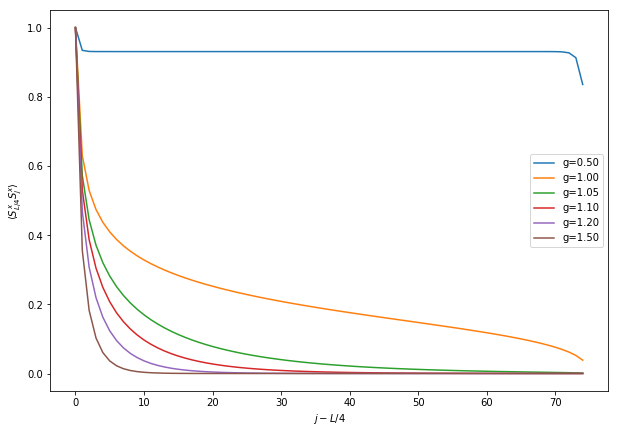

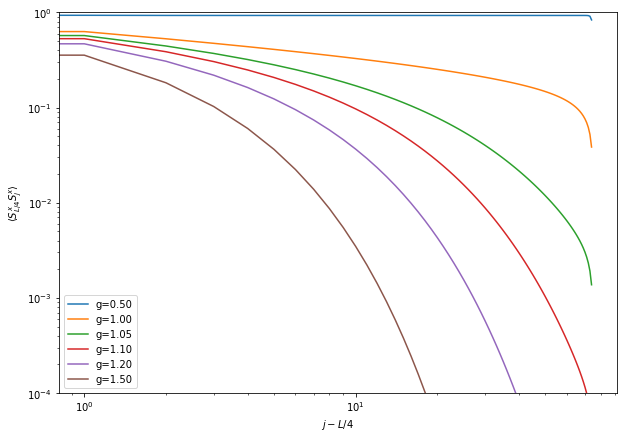

In [15]:
# plot the correlations
plt.figure(figsize=(10, 7))
sx = model.sigmax
for g in sorted(corrs.keys()):
    plt.plot(corrs[g], label="g={g:.2f}".format(g=g))
plt.xlabel("$j - L/4$")
plt.ylabel(r"$\langle S^x_{L/4} S^x_j\rangle$")
plt.legend(loc='best')
plt.show()

# and again on a log-log-scale:
# at the critical point, it should decay like a powerlaw (= straight line )
plt.figure(figsize=(10, 7))
sx = model.sigmax
for g in sorted(corrs.keys()):
    plt.plot(corrs[g], label="g={g:.2f}".format(g=g))
plt.xlabel("$j - L/4$")
plt.ylabel(r"$\langle S^x_{L/4} S^x_j\rangle$")
plt.loglog()
plt.ylim(1.e-4, 1.)
plt.legend(loc='best')
plt.show()

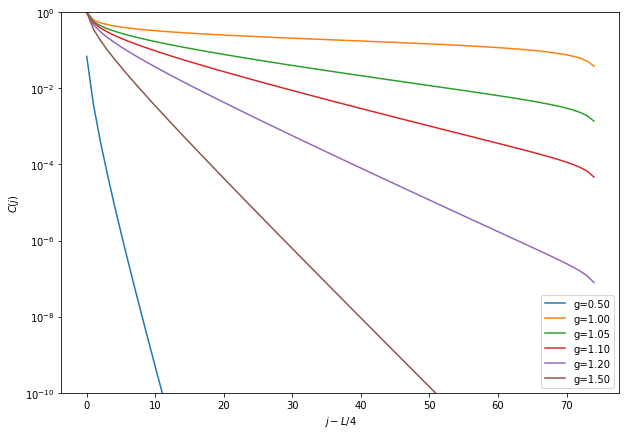

In [16]:
# g) connected correlations
plt.figure(figsize=(10, 7))
sx = model.sigmax
for g in sorted(conn_corrs.keys()):
    plt.plot(conn_corrs[g], label="g={g:.2f}".format(g=g))
plt.xlabel("$j - L/4$")
plt.ylabel("$C(j)$")
plt.yscale('log')
plt.ylim(1.e-10, 1.)
plt.legend(loc='best')
plt.show()

## interpretation
Right at the critical point $g = J$ we expect/observe a powerlaw decay,
for $g < J$ we have long-range order, so $C(j) \rightarrow <Sx><Sx> = const$,
and for $g > J$ the correlations decay exponentially.

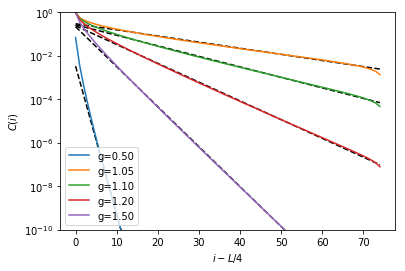

In [17]:
gs_fit = [g for g in gs if g != 1.]
xis_fit = []
plt.figure()
for g in gs_fit:
    C = np.array(conn_corrs[g])
    log_C = np.log(conn_corrs[g])
    x = np.arange(len(log_C))
    include_to_fit = np.logical_and(C > 1.e-12, np.logical_and(x > 5, x < len(C)-10))
    pol = np.polyfit(x[include_to_fit], log_C[include_to_fit], 1)
    slope, const = pol
    fit = np.exp(slope*x + const)
    plt.plot(x, fit, 'k--')
    xis_fit.append(-1./slope)
    plt.plot(conn_corrs[g], label="g={g:.2f}".format(g=g))

plt.xlabel("$i - L/4$")
plt.ylabel("$C(i)$")
plt.yscale('log')
plt.ylim(1.e-10, 1.)
plt.legend(loc='best')
plt.show()
    

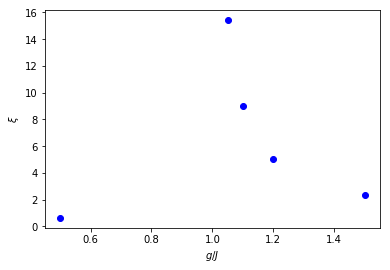

In [18]:
plt.figure()
plt.plot(gs_fit, xis_fit, 'bo')
plt.xlabel("$g/J$")
plt.ylabel("$\\xi$")
plt.show()